In [17]:
from pathlib import Path
import webbrowser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

from evolution.evaluation.evaluator import EnROADSEvaluator
from experiments.experiment_utils import NNExperimenter, DirectExperimenter
from enroadspy import load_input_specs, id_to_name
from enroadspy.generate_url import actions_to_url

In [18]:
results_dir = Path("results/all-action-direct-decomplexify")
with open(results_dir / "config.yml", "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

gens = len(list(results_dir.glob("[0-9]*.csv")))-1
context = config["context"]
actions = config["actions"]
outcomes = config["outcomes"]
outcome_keys = list(outcomes.keys())
n_elites = config["evolution_params"]["n_elites"]
print(gens, outcomes, len(actions), len(context))

399 {'Action magnitude': True, 'Actions taken': True, 'Temperature change from 1850': True} 102 0


In [19]:
input_specs = load_input_specs()

evaluator = EnROADSEvaluator(context, actions, outcomes, n_jobs=1, batch_size=config["batch_size"], device=config["device"])
if len(context) > 0:
    experimenter = NNExperimenter(results_dir)
else:
    experimenter = DirectExperimenter(results_dir)

make: `enroads' is up to date.
make: `enroads' is up to date.


In [20]:
def filter_actions_dict(actions_dict: dict):
    input_specs = load_input_specs()
    filtered = {}
    for action in actions_dict:
        default = input_specs[input_specs["varId"] == action]["defaultValue"].values[0]
        if actions_dict[action] != default:
            filtered[action] = actions_dict[action]
    return filtered

200
{'Apply carbon tax to biofuels': 0.89, 'Carbon tax phase 3 start': 0.7597583007812502, 'Utilization adjustment factor delivered oil': 0.748193358612059, 'Carbon tax final target': 0.6969756397920501, 'Percent available land for afforestation': 0.587052526473999, 'Target change in other GHGs for crops': 0.5476012144955724, 'Biochar Percent of max CDR achieved': 0.47930168647766086, 'Target change f gas': 0.39559278425303357, 'No new bio': 0.3491084327697753, 'Target change other GHGs waste': 0.3006758396408774, 'Mineralization Percent of max CDR achieved': 0.25668535308837903, 'Target change in other GHGs for LS': 0.2497112908146599, 'DAC Percent of max CDR achieved': 0.1846958366394043, 'Carbon tax initial target': 0.14694036323547371, 'Ag soil carbon Percent of max CDR achieved': 0.09573641853332521, 'Utilization adjustment factor delivered gas': 0.08636799831390381, 'Carbon tax time to achieve initial target': 0.07232782315726236, 'Electric Standard Active': 0.025, 'Carbon tax ti

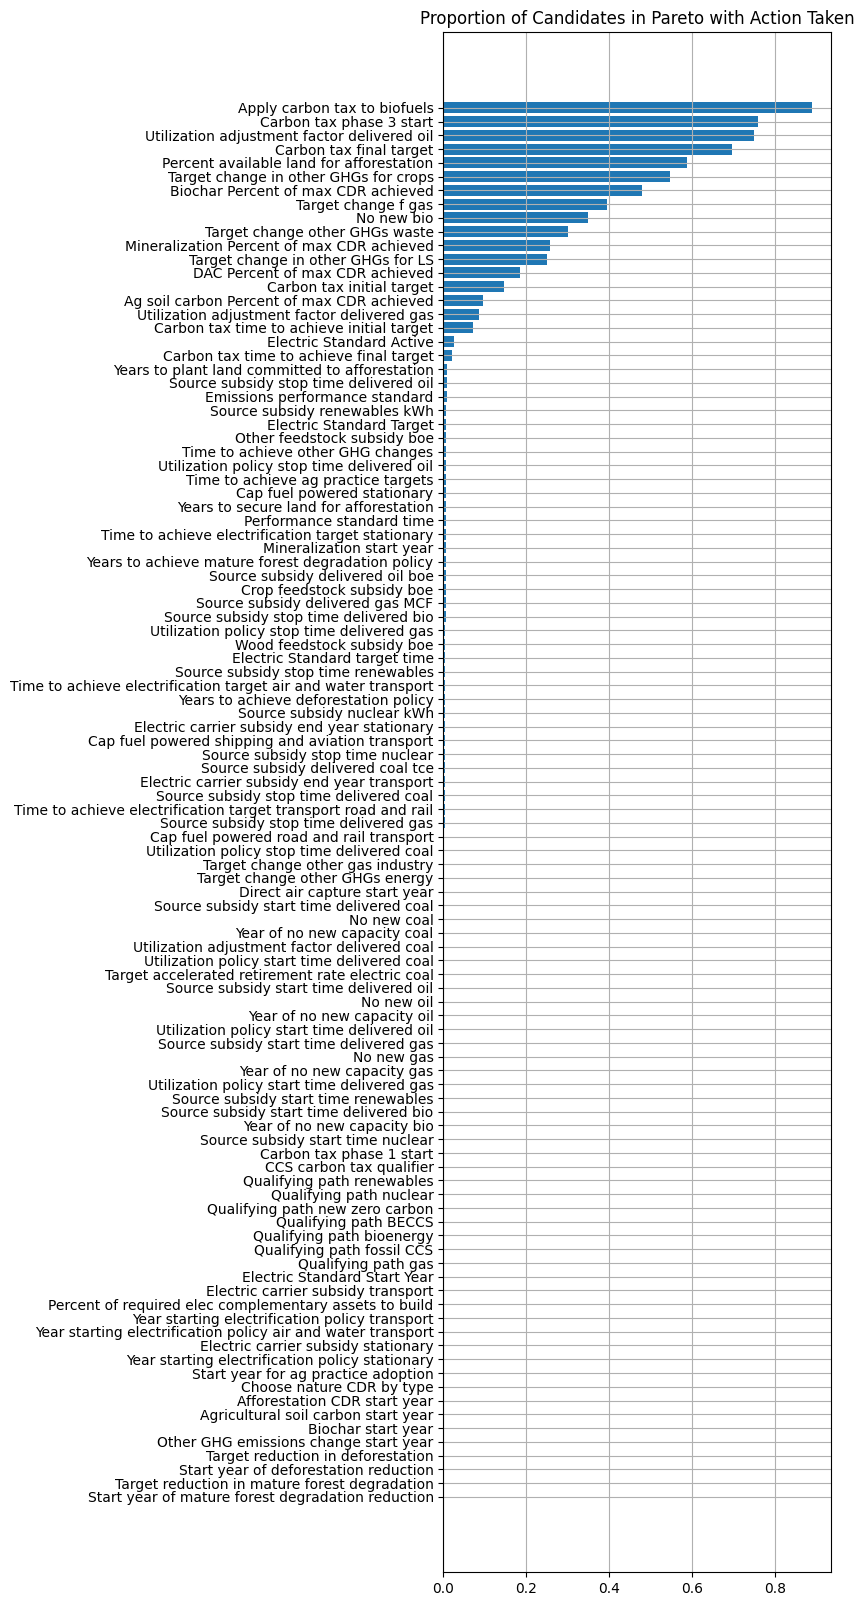

In [ ]:
def plot_actions_taken(gen: int, magnitude=False):
    gen_df = pd.read_csv(results_dir / f"{gen}.csv")
    gen_df = gen_df[gen_df["rank"] == 1]
    pareto_len = len(gen_df)
    print(pareto_len)
    actions_count = {action: 0 for action in actions}
    for cand_id in gen_df["cand_id"]:
        [context_actions_dict], _, _ = experimenter.get_candidate_results(cand_id)
        for action in context_actions_dict:
            row = input_specs[input_specs["varId"] == action].iloc[0]
            default_value = row["defaultValue"]
            if action not in context and context_actions_dict[action] != default_value:
                if not magnitude:
                    actions_count[action] += 1
                else:
                    min_value = row["minValue"] if row["kind"] == "slider" else row["offValue"]
                    max_value = row["maxValue"] if row["kind"] == "slider" else row["onValue"]
                    if min_value == max_value:
                        continue
                    norm = (context_actions_dict[action] - min_value) / (max_value - min_value)
                    default_norm = (default_value - min_value) / (max_value - min_value)
                    actions_count[action] += abs(norm - default_norm)

    # Switch to nice name, normalize values
    actions_count = {action: count / pareto_len for action, count in actions_count.items()}
    actions_count = dict(sorted(actions_count.items(), key=lambda item: item[1], reverse=True))
    pretty_actions_count = {id_to_name(action, input_specs): count for action, count in actions_count.items()}

    print(pretty_actions_count)
    fig, ax = plt.subplots(figsize=(5, 20))
    ax.barh(pretty_actions_count.keys(), pretty_actions_count.values())
    ax.set_title("Proportion of Candidates in Pareto with Action Taken")
    ax.grid()
    ax.invert_yaxis()
    plt.show()

    return actions_count

actions_count = plot_actions_taken(gens, magnitude=False)

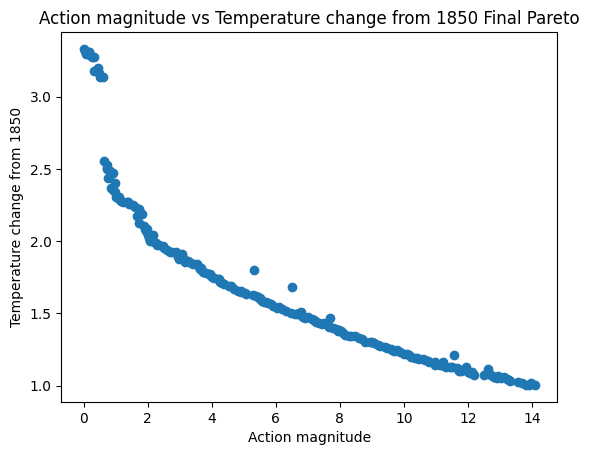

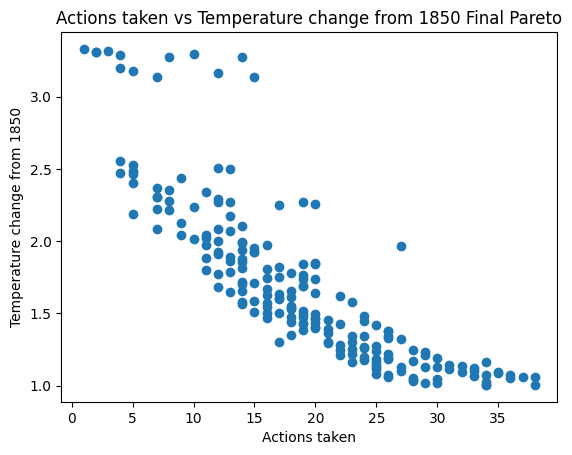

In [41]:
def plot_pareto(outcome1, outcome2, gen, colored_ids=[]):

    gen_df = pd.read_csv(results_dir / f"{gen}.csv")
    gen_df = gen_df[gen_df["rank"] == 1]
    gen_df["color"] = gen

    plt.scatter(gen_df[outcome1], gen_df[outcome2])

    colors = ["pink", "lightgreen"]
    for colored_id, color in zip(colored_ids, colors):
        colored_df = gen_df[gen_df["cand_id"] == colored_id]
        plt.scatter(colored_df[outcome1], colored_df[outcome2], color=color)

    title = f"{outcome1} vs {outcome2} Final Pareto"
    plt.title(title)
    plt.ylabel(outcome2)
    plt.xlabel(outcome1)
    plt.show()

plot_pareto(outcome_keys[0], outcome_keys[2], gens)
plot_pareto(outcome_keys[1], outcome_keys[2], gens)

     cand_id  Temperature change from 1850  Actions taken  Action magnitude
0        1_2                       3.32968            1.0      9.536743e-09
6    256_110                       3.31874            3.0      2.516284e-02
68   163_147                       3.30597            2.0      1.569565e-01
69   318_177                       3.30597            2.0      1.569565e-01
34   261_106                       3.29687           10.0      8.036645e-02
44     228_7                       3.28622            4.0      1.786110e-01
41    323_63                       3.27605            8.0      2.531200e-01
8     373_40                       3.27135           14.0      3.235499e-01
16    288_32                       3.20063            4.0      4.357936e-01
21   351_138                       3.17464            5.0      3.297397e-01
102   301_22                       3.16566           12.0      4.892179e-01
26   399_168                       3.13837            7.0      5.046130e-01
4     337_83

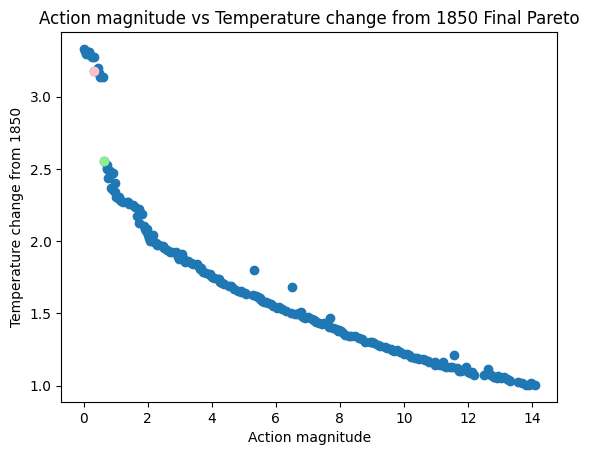

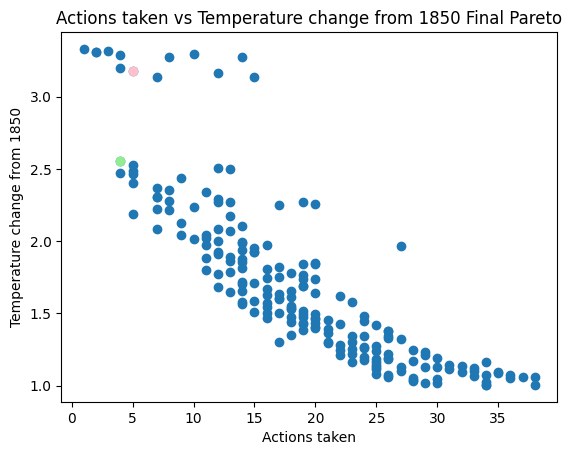

In [42]:
pareto_df = pd.read_csv(results_dir / f"{gens}.csv")
pareto_df = pareto_df[pareto_df["rank"] == 1]
pareto_df = pareto_df.sort_values(by=[outcome_keys[2], outcome_keys[1], outcome_keys[0]], ascending=False)

print(pareto_df[["cand_id", outcome_keys[2], outcome_keys[1], outcome_keys[0]]].head(20))
# 57_162, 63_147
special = ["351_138", "397_26"]
plot_pareto(outcome_keys[0], outcome_keys[2], gens, special)
plot_pareto(outcome_keys[1], outcome_keys[2], gens, special)

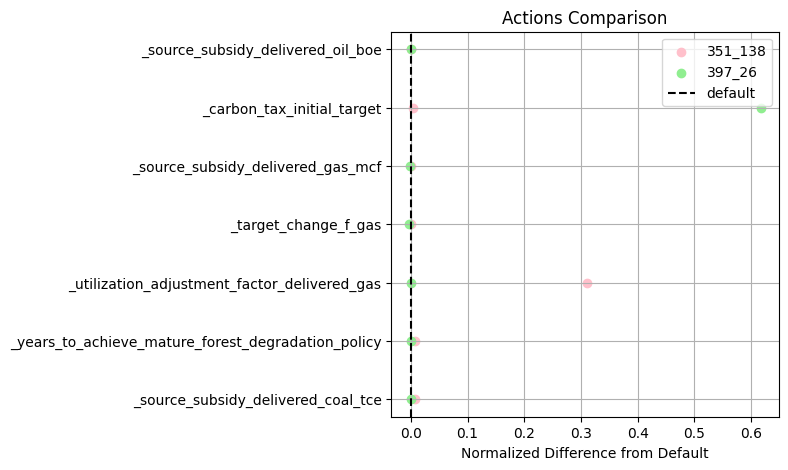

In [46]:
def compare_actions(cand_1, cand_2):
    [ca_1], _, _ = experimenter.get_candidate_results(cand_1)
    [ca_2], _, _ = experimenter.get_candidate_results(cand_2)

    total_actions = list(set(ca_1.keys()).union(set(ca_2.keys())))

    all_actions = []
    norm1s = []
    norm2s = []
    defaults = []
    mins = []
    maxes = []

    for action in total_actions:
        row = input_specs[input_specs["varId"] == action].iloc[0]
        default_value = row["defaultValue"]
        min_value = row["minValue"] if row["kind"] == "slider" else row["offValue"]
        max_value = row["maxValue"] if row["kind"] == "slider" else row["onValue"]

        if ca_1[action] == default_value and ca_2[action] == default_value:
            continue

        if min_value == max_value:
            norm_1 = 1
            norm_2 = 1
            norm_default = 1

        else:
            norm_default = (default_value - min_value) / (max_value - min_value)
            norm_1 = (ca_1[action] - min_value) / (max_value - min_value)
            norm_2 = (ca_2[action] - min_value) / (max_value - min_value)

            diff_1 = norm_1 - norm_default
            diff_2 = norm_2 - norm_default

        norm1s.append(diff_1)
        norm2s.append(diff_2)
        defaults.append(norm_default)
        mins.append(min_value)
        maxes.append(max_value)
        all_actions.append(action)

    df = pd.DataFrame({"action": all_actions,
                       "norm1": norm1s,
                       "norm2": norm2s,
                       "default": defaults,
                       "min": mins,
                       "max": maxes})
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(df["norm1"], range(len(df)), label=cand_1, color="pink")
    ax.scatter(df["norm2"], range(len(df)), label=cand_2, color="lightgreen")
    ax.axvline(x=0, color="black", linestyle="--", label="default")

    ax.set_xlabel("Normalized Difference from Default")
    ax.set_yticks(range(len(df)), df["action"])
    ax.set_title("Actions Comparison")
    ax.grid()
    ax.legend()

    plt.show()

compare_actions(*special)

In [25]:
def print_actions_dict(cand_id):
    [context_actions_dict], [outcomes_df], _ = experimenter.get_candidate_results(cand_id)
    true_ca_dict = {}
    for action in context_actions_dict:
        default_value = input_specs[input_specs["varId"] == action]["defaultValue"].values[0]
        if context_actions_dict[action] != default_value:
            true_ca_dict[action] = context_actions_dict[action]
    print(true_ca_dict)

In [26]:
for cand_id in special:
    print_actions_dict(cand_id)

{'_source_subsidy_delivered_coal_tce': 0.9281978607177734, '_source_subsidy_delivered_oil_boe': 0.00238037109375, '_utilization_adjustment_factor_delivered_gas': 31.078353881835938, '_carbon_tax_initial_target': 5.8643012046813965, '_years_to_achieve_mature_forest_degradation_policy': 30.555286407470703}
{'_source_subsidy_delivered_oil_boe': 9.5367431640625e-07, '_source_subsidy_delivered_gas_mcf': -0.009994864463806152, '_carbon_tax_initial_target': 159.486328125, '_target_change_f_gas': -0.3583822250366211}


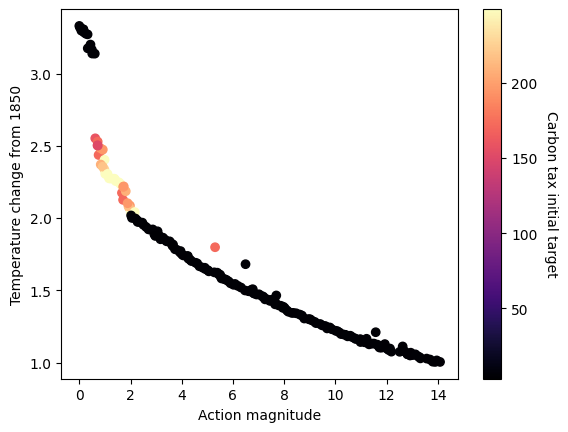

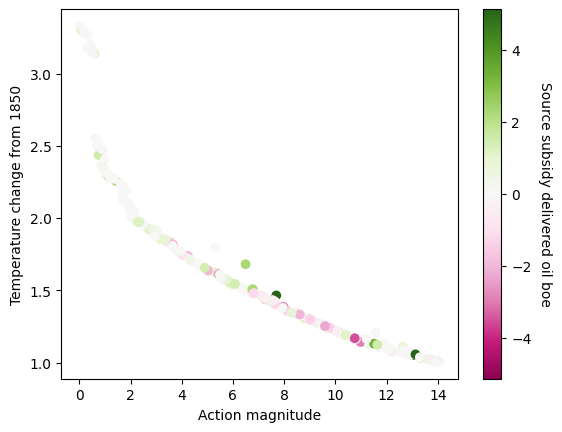

In [47]:
def color_pareto_by_action(action: str, outcome_1: str, outcome_2: str):
    pareto_df = pd.read_csv(results_dir / f"{gens}.csv")
    pareto_df = pareto_df[pareto_df["rank"] == 1]

    action_vals = []
    for cand_id in pareto_df["cand_id"]:
        [context_actions_dict], _, _ = experimenter.get_candidate_results(cand_id)
        action_vals.append(context_actions_dict[action])
    
    pareto_df["action"] = action_vals

    fig, ax = plt.subplots()
    min_val = min(action_vals)
    max_val = max(action_vals)
    if min_val < 0 and max_val > 0:
        cmap_params = {"cmap": "PiYG", "vmin": min(min_val, -max_val), "vmax": max(-min_val, max_val)}
    else:
        cmap_params = {"cmap": "magma"}
    scatter = ax.scatter(pareto_df[outcome_1], pareto_df[outcome_2], c=pareto_df["action"], **cmap_params)
    ax.set_xlabel(outcome_1)
    ax.set_ylabel(outcome_2)
    cbar = fig.colorbar(scatter)
    cbar.set_label(id_to_name(action, load_input_specs()), rotation=270, labelpad=15)
    plt.show()

color_pareto_by_action("_carbon_tax_initial_target", outcome_keys[0], outcome_keys[2])
color_pareto_by_action("_source_subsidy_delivered_oil_boe", outcome_keys[0], outcome_keys[2])

In [ ]:
[context_actions_dict], _, _ = experimenter.get_candidate_results(pareto_df.sort_values(outcome_keys[2])["cand_id"].values[0])
print(filter_actions_dict(context_actions_dict))
context_actions_dict = evaluator.decomplexify_actions_dict(context_actions_dict)
url = actions_to_url(context_actions_dict)
webbrowser.open(url)

{'_source_subsidy_delivered_oil_boe': 9.5367431640625e-07, '_source_subsidy_stop_time_delivered_oil': 2098.446533203125, '_utilization_adjustment_factor_delivered_oil': 99.95361328125, '_utilization_policy_stop_time_delivered_oil': 2098.637939453125, '_utilization_adjustment_factor_delivered_gas': 98.57134246826172, '_source_subsidy_stop_time_renewables': 2095.861328125, '_source_subsidy_stop_time_delivered_bio': 2096.958984375, '_no_new_bio': 96.34101104736328, '_other_feedstock_subsidy_boe': 1.2133235931396484, '_carbon_tax_initial_target': 4.65709114074707, '_carbon_tax_time_to_achieve_initial_target': 1.0424801111221313, '_carbon_tax_final_target': 808.5535888671875, '_carbon_tax_phase_3_start': 2024.0, '_carbon_tax_time_to_achieve_final_target': 7.489273548126221, '_apply_carbon_tax_to_biofuels': 1.0, '_electric_standard_target': 73.15056610107422, '_electric_standard_target_time': 13.2907133102417, '_performance_standard_time': 2096.85546875, '_cap_fuel_powered_shipping_and_aviat

True

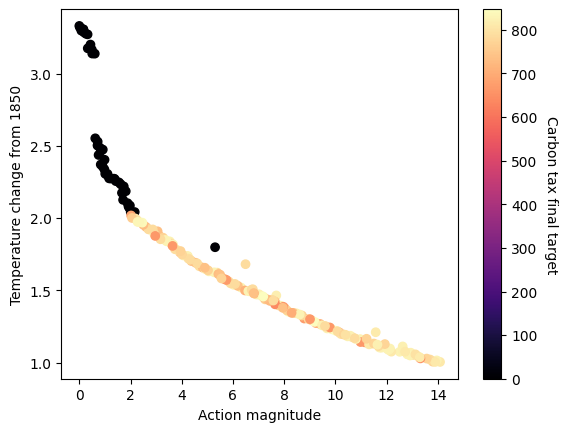

In [37]:
color_pareto_by_action("_carbon_tax_final_target", outcome_keys[0], outcome_keys[2])